In [125]:
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# scaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestRegressor

# Models
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load Data

In [126]:
rumah123_df = pd.read_csv("../../data/rumah123_ready.csv")

### Mean Encoding

In [127]:
# Mean encoding pada kolom 'location' terhadap target 'price'
mean_encoded = rumah123_df.groupby('location')['price'].mean()
rumah123_df['location'] = rumah123_df['location'].map(mean_encoded)

In [128]:
joblib.dump(mean_encoded.to_dict(), '../../models/mean_encoder.joblib')

['../../models/mean_encoder.joblib']

### Splitting

In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = rumah123_df.drop(columns=['price'])
y = rumah123_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.index.size)
print(X_test.index.size)

11679
2920


In [130]:
rumah123_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14599 entries, 0 to 14598
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          14599 non-null  float64
 1   bedroom        14599 non-null  int64  
 2   bathroom       14599 non-null  int64  
 3   land_area      14599 non-null  int64  
 4   building_area  14599 non-null  int64  
 5   location       14599 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 684.5 KB


# Feature Scalling

In [131]:
# Inisiasi metode scalling
scalers = {
    'Standard': StandardScaler(),
    'MinMax':   MinMaxScaler(),
    'Robust':   RobustScaler(),
    'MaxAbs':   MaxAbsScaler()
}

In [132]:
# evaluasi tiap scaler
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, scaler in scalers.items():
    pipeline = Pipeline([
        ('scaler', scaler),
        ('reg',    RandomForestRegressor(random_state=42))
    ])
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1)
    results.append({
        'Scaler':    name,
        'Mean R²':   np.mean(scores),
        'Std Dev R²': np.std(scores)
    })

In [133]:
# tampilkan hasil scalernya
scaler_results = pd.DataFrame(results).sort_values('Mean R²', ascending=False).reset_index(drop=True)
scaler_results

,Scaler,Mean R²,Std Dev R²
0,MinMax,0.667133,0.011488
1,Standard,0.666876,0.011458
2,Robust,0.666786,0.011108
3,MaxAbs,0.666684,0.011945


In [134]:
# Normalisasi dengan MinMaxScaler
best_scaler_name = scaler_results.iloc[0]['Scaler']
best_scaler = scalers[best_scaler_name]
X_train_scaled = best_scaler.fit_transform(X_train)
X_test_scaled = best_scaler.transform(X_test)

joblib.dump(best_scaler, '../../models/scaler.joblib')

['../../models/scaler.joblib']

# Modeling

In [135]:
# Inisialisasi model
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

In [136]:
# Evaluasi model
def model_selection_regression(X_train, X_test, y_train, y_test):
    results = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        results.append({
            'Model': name,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2
        })

    results_df = pd.DataFrame(results)
    return results_df.sort_values(by='R²', ascending=False)

In [137]:
results = model_selection_regression(X_train_scaled, X_test_scaled, y_train, y_test)
results

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 479
[LightGBM] [Info] Number of data points in the train set: 11679, number of used features: 5
[LightGBM] [Info] Start training from score 1226.017296


,Model,MAE,MSE,RMSE,R²
4,CatBoost,202.622570,68974.181622,262.629362,0.693898
2,XGBoost,200.995842,68978.428270,262.637446,0.693879
3,LightGBM,205.031025,70430.992618,265.388381,0.687433
0,Random Forest,199.045497,71644.175299,267.664296,0.682049
1,Extra Trees,204.232410,77908.970171,279.121784,0.654246


In [138]:
def plot_best_model_reg(X_train, X_test, y_train, y_test):
    
    results_df = model_selection_regression(X_train, X_test, y_train, y_test)
    
    # Ambil model terbaik
    best_model_name = results_df.iloc[0]['Model']
    best_model = models[best_model_name]
    
    # Fit dan prediksi
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Aktual')
    plt.ylabel('Prediksi')
    plt.title(f'Perbandingan Aktual vs Prediksi (Model Terbaik: {best_model_name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 479
[LightGBM] [Info] Number of data points in the train set: 11679, number of used features: 5
[LightGBM] [Info] Start training from score 1226.017296


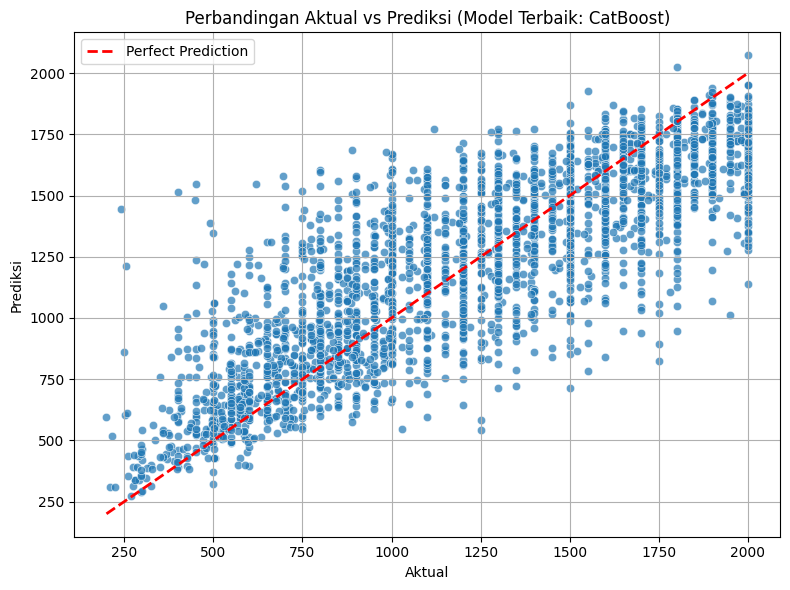

In [139]:
plot_best_model_reg(X_train_scaled, X_test_scaled, y_train, y_test)